In [107]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from numpy import polyfit

from statsmodels.tsa import stattools

### Read data

In [35]:
pollution = pd.read_csv(
    'https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/Air%20pollution%20by%20city%20-%20Fouquet%20and%20DPCC%20(2011)/Air%20pollution%20by%20city%20-%20Fouquet%20and%20DPCC%20(2011).csv'
)

### Explore data

In [36]:
print(len(pollution))
print(pollution.columns)

331
Index(['Entity', 'Year', 'Smoke (Fouquet and DPCC (2011))',
       'Suspended Particulate Matter (SPM) (Fouquet and DPCC (2011))'],
      dtype='object')


In [37]:
pollution = pollution.rename(columns={
    'Suspended Particulate Matter (SPM) (Fouquet and DPCC (2011))': 'SPM',
    'Smoke (Fouquet and DPCC (2011))' : 'Smoke',
    'Entity': 'City'
})

In [38]:
print(pollution.dtypes)

print(pollution.City.unique())

print(pollution.Year.min(), pollution.Year.max())

City      object
Year       int64
Smoke    float64
SPM      float64
dtype: object
['Delhi' 'London']
1700 2016


In [39]:
pollution.Smoke.unique().size

286

### Transform data

In [40]:
pollution['Year'] = pollution['Year'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y'))
pollution.dtypes

City             object
Year     datetime64[ns]
Smoke           float64
SPM             float64
dtype: object

In [41]:
pollution.isnull().mean()

City     0.000000
Year     0.000000
Smoke    0.090634
SPM      0.000000
dtype: float64

### Plot

Text(0, 0.5, 'Frequency')

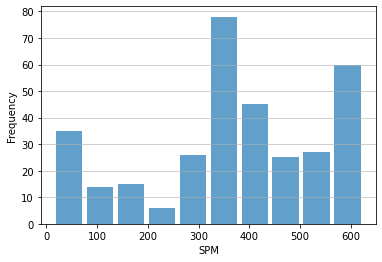

In [45]:
plt.hist(
    x=pollution['SPM'], 
    bins='auto',
    alpha=0.7,
    rwidth=0.85
)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('SPM')
plt.ylabel('Frequency')

### Stats

In [54]:
def ignore_nans(a, b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]

stats.pearsonr(*ignore_nans(pollution['Smoke'], pollution['SPM']))

PearsonRResult(statistic=1.0, pvalue=0.0)

### Plot

Text(333.4714285714286, 0.5, 'SPM')

<Figure size 864x432 with 0 Axes>

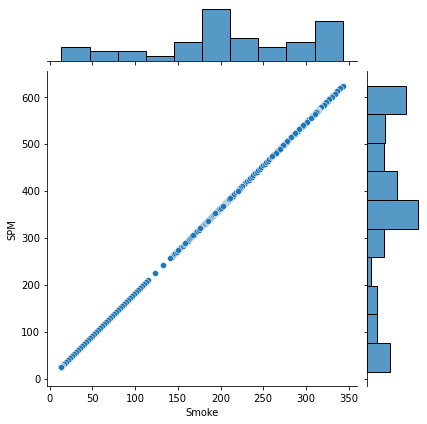

In [57]:
plt.figure(figsize=(12, 6))
sns.jointplot(
    x='Smoke',
    y='SPM',
    edgecolor='white',
    data=pollution
)
plt.xlabel('Smoke')
plt.ylabel('SPM')

### Autocorrelation

In [104]:
pollution = pollution.pivot(index='Year', columns='City', values='SPM')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

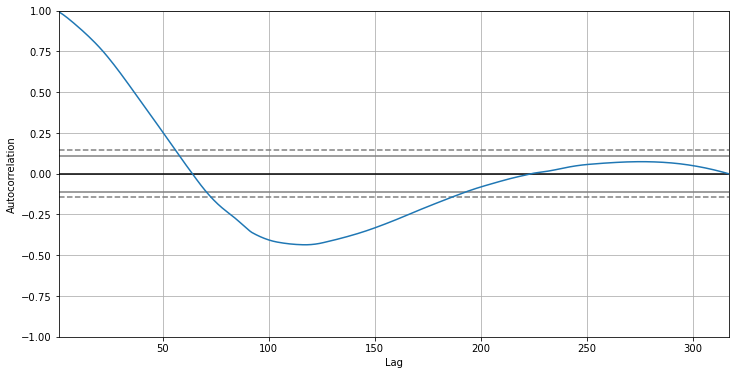

In [106]:
plt.figure(figsize=(12, 6))
pd.plotting.autocorrelation_plot(pollution['London'])

In [108]:
stattools.adfuller(pollution['London'])

(-0.3372164080424261,
 0.9200654843183901,
 13,
 303,
 {'1%': -3.4521175397304784,
  '5%': -2.8711265007266666,
  '10%': -2.571877823851692},
 1684.699266349387)

# Trend and seasonality

In [70]:
temperatures = pd.read_csv('monthly.csv')
temperatures['Date'] = pd.to_datetime(temperatures['Date'])
temperatures.head(4)

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300


In [71]:
temperatures = temperatures.pivot(index='Date', columns='Source', values='Mean')
temperatures.head(4)

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27


### Fitting curve

In [98]:
def fit(X, y, degree=3):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)

def get_season(s, yearly_periods=4, degree=3):
    X = [i%(365/yearly_periods) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)

def get_trend(s, degree=3):
    X = list(range(len(s)))
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)

Text(0, 0.5, 'Temperature change')

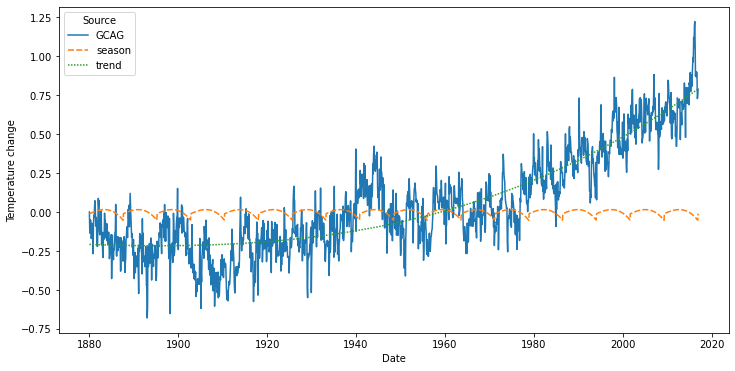

In [102]:
plt.figure(figsize=(12, 6))

temperatures['trend'] = get_trend(temperatures['GCAG'])
temperatures['season'] = get_season(temperatures['GCAG'] - temperatures['trend'])
sns.lineplot(data=temperatures[['GCAG', 'season', 'trend']])
plt.ylabel('Temperature change')